In [2]:
import torch, torchvision
import matplotlib.pyplot as plt
import kornia
import tqdm
import numpy as np
import einops
import timm
from PIL import Image




with open("imagenet1000_clsidx_to_labels.txt", 'r') as labels_file:
    labels = labels_file.read().splitlines()




In [17]:
input_img.shape

torch.Size([1, 1, 224, 224])

In [23]:
input_img.max()

tensor(0.4980)

In [18]:
angle

tensor([[[[-3.1416,  0.5768, -0.1322,  ..., -2.9700,  0.1322, -0.5768],
          [ 0.1133,  0.9812,  1.1361,  ..., -1.8189,  1.6525,  2.2274],
          [-2.4404,  1.3650, -1.9278,  ...,  1.0946, -2.3513, -0.0911],
          ...,
          [-1.1158,  1.4174, -0.6618,  ...,  0.7807, -3.1034, -1.3270],
          [ 2.4404,  0.0911,  2.3513,  ..., -1.9146,  1.9278, -1.3650],
          [-0.1133, -2.2274, -1.6525,  ...,  1.3577, -1.1361, -0.9812]]]])

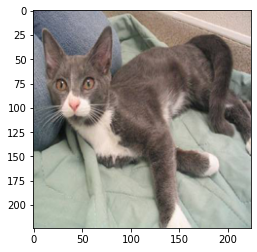

Mag range:0.013466067612171173 -- 27827.28125
LogMag range:0.0013070654822513461 -- 1.0


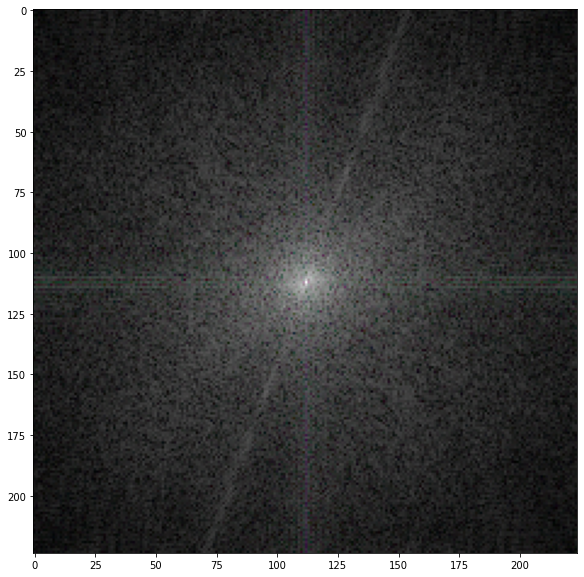

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


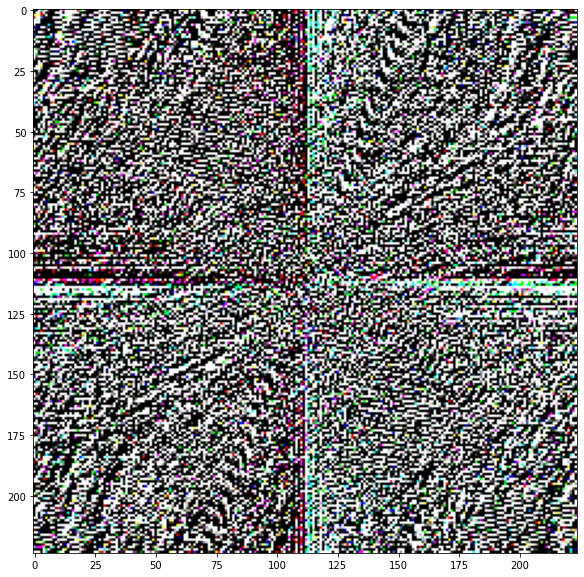

In [25]:


from kornia import tensor_to_image as t2i


input_img = torchvision.transforms.functional.to_tensor(
    Image.open('./inputs/cat.jpg').resize([224, 224])
).unsqueeze(0)



plt.imshow(t2i(input_img[0])); plt.show()


input_img_fft = torch.fft.fftshift(
    torch.fft.fft2(input_img)
)


mag, angle = input_img_fft.abs(), input_img_fft.angle()

print(f"Mag range:{mag.min().item()} -- {mag.max().item()}")

log_mag = torch.log(mag+1)
log_mag /= log_mag.max()

print(f"LogMag range:{log_mag.min().item()} -- {log_mag.max().item()}")


plt.figure(figsize=[10, 10]);plt.imshow(t2i(log_mag)); plt.show()
plt.figure(figsize=[10, 10]);plt.imshow(t2i(angle)); plt.show()


# reconstruction = 


In [55]:
mag.min()

tensor(0.)

100%|██████████| 1000/1000 [00:32<00:00, 31.06it/s]


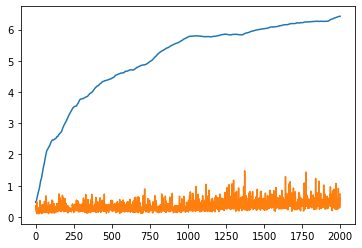

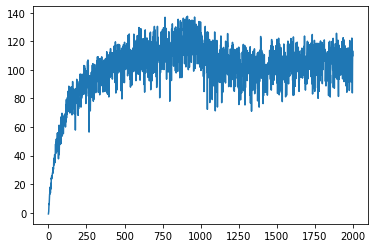

In [28]:


ITERATIONS = 1000



for n in tqdm.tqdm(range(ITERATIONS)):

   
    input_img = torch.sigmoid(input_tensor)          
    tv_loss = kornia.losses.total_variation(input_img).mean()


    target_losses = []
    for n, net_dict in enumerate(network_dicts):
        net = net_dict['net']
        input_img_batch = einops.repeat(input_img, 'b c h w -> (b repeat) c h w', repeat = 4)
        transformed_input_img_batch = batch_transforms(input_img_batch)
          
        out = net(transformed_input_img_batch)
        target = out[:, TARGET_CLASSES].mean()
        target_losses.append(-target / len(network_dicts))
        
        activations[n].append(target.item())
        
        
    

    loss = tv_loss * 1e-2
    for target_loss in target_losses:
        loss = loss + target_loss
 
    loss.backward()
    


    max_list.append(abs(input_tensor.max().item()))
    grads_max_list.append(abs(input_tensor.grad.max().item()))
    
    optimizer.step()
    optimizer.zero_grad()
    

plt.figure(); 
plt.plot(max_list); 
plt.plot(grads_max_list); 
plt.show()



plt.figure(); 
[plt.plot(t) for t in activations]; 
plt.show()





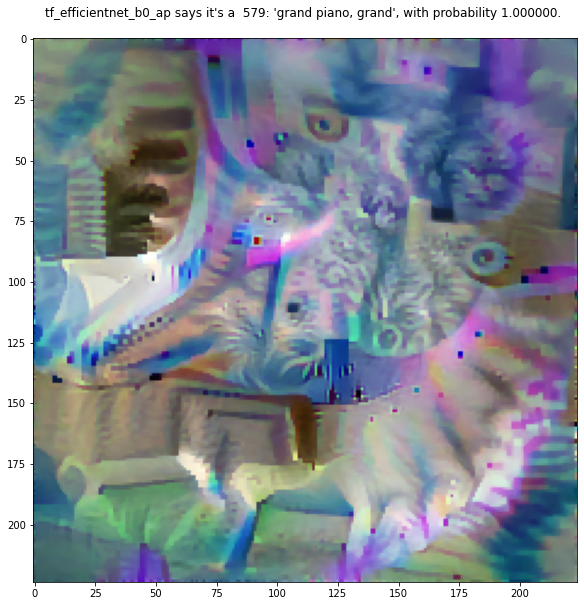

In [30]:
plt.figure(figsize=[10, 10])

plt.imshow(kornia.tensor_to_image(input_img[0]))


title_string = ''
with torch.no_grad():
    for n, net_dict in enumerate(network_dicts):
        net = net_dict['net']
        out = net(input_img)
        out_argmax = torch.argmax(out, -1).item()
        out_probs = torch.softmax(out, -1)[0]
        out_label = labels[out_argmax]
        out_prob  = out_probs[out_argmax].item()
        title_string += f"{net_dict['name']} says it's a {out_label} with probability {out_prob:0.6f}. \n" 
        

plt.title(title_string)
plt.show()





In [7]:
out_probs.shape

torch.Size([1000])